# Basic usage of the cosmoDC2 extragalactic catalog and photoz add-on catalog

### Compute the excess surface density arround clusters using photometrical redshift in cosmoDC2 extragalactic catalog

#### This notebook can be run at NERSC or CC-IN2P3 where the DESC DC2 products are stored. You need to be a DESC member to be able to access those.

This notebook will show how to use the photometric redshift (photo-z) add-on columns of cosmoDC2 extragalactic catalog in order to estimate the average excess surface density around cluster. After going through this notebook, you should be able to access:
- load a cosmoDC2 dark matter halo catalog,
- load and access the cosmoDC2 extragalctic catalog + photo-z add-on columns (a detailled version of this step was edited by Sam Shmidt and is available at https://github.com/LSSTDESC/DC2-analysis/blob/master/tutorials/extragalactic_gcr_photoz_catalogs.ipynb),
- Calculate the specific weights to compute the mean excess surface density around cluster.

In [1]:
import numpy as np
import GCRCatalogs
import matplotlib.pyplot as plt
import scipy.integrate

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, join
import GCRCatalogs
try: import clmm
except:
    import notebook_install
    notebook_install.install_clmm_pipeline(upgrade=False)
    import clmm
    
import healpy

# 1. Prepare a dark matter halo from cosmoDC2

In [3]:
extragalactic_cat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')

In order to speed up the extraction of dark matter halo/galaxy quantities, we select a dark matter halo within a specified healpix pixel. 

In [4]:
healpix_pixels = extragalactic_cat.get_catalog_info()['healpix_pixels']

In [5]:
healpix_selected = healpix_pixels[10]
print('The selected healpix pixel is ' + str(healpix_selected))

The selected healpix pixel is 10072


We extract the dark matter halos located in this specified healpix pixel with some property cut (mass and redhift range). We select the most massive one in the sample.

In [6]:
# get list of massive halos in a given redshift and mass range
mmin = 1.e14 # Msun
zmin = 0.
zmax = 1
massive_halos = extragalactic_cat.get_quantities(['halo_mass','hostHaloMass','redshift','ra', 'dec', 'halo_id'],
                                                 filters=[f'halo_mass > {mmin}','is_central==True',
                                                          f'redshift>{zmin}', f'redshift<{zmax}'], native_filters=['healpix_pixel == ' + str(healpix_selected)])
N_cl = len(massive_halos['halo_mass'])
print(f'There are {N_cl} clusters in this mass and redshift range')

There are 47 clusters in this mass and redshift range


In [7]:
select = massive_halos['halo_mass'] == np.max(massive_halos['halo_mass'])
ra_cl = massive_halos['ra'][select][0]
dec_cl = massive_halos['dec'][select][0]
z_cl = massive_halos['redshift'][select][0]
mass_cl =massive_halos['halo_mass'][select][0]
id_cl = massive_halos['halo_id'][select][0]

In [8]:
print (f'The most massive cluster is halo {id_cl} in ra = {ra_cl:.2f} deg, dec = {dec_cl:.2f} deg, z = {z_cl:.2f}, with mass = {mass_cl:.2e} Msun')

The most massive cluster is halo 93100157401 in ra = 67.48 deg, dec = -40.93 deg, z = 0.22, with mass = 7.82e+14 Msun


# 2. Extract background galaxy catalog with location and shape properties

### Apply coordinates, redshift and magnitude cuts to select backgroud galaxies around the cluster

- Box of 0.6 deg around the cluster center
- Galaxies redshift > cluster redshift + 0.1
- Galaxies with mag_i < 25

In [9]:
ra_min, ra_max = ra_cl - 0.3, ra_cl + 0.3
dec_min, dec_max = dec_cl - 0.3, dec_cl + 0.3
z_min = z_cl + 0.1
mag_i_max = 25

We load the catalog in the contiguous healpix pixels arround the cluster position corresponding to a window O.6 deg (healpy package)

In [10]:
n_points = 300
ra_random, dec_random = np.random.random(n_points)*(ra_max - ra_min) + ra_min, np.random.random(n_points)*(dec_max - dec_min) + dec_min
contiguous_healpix_pixels = np.unique(healpy.ang2pix(32, ra_random, dec_random, nest=False, lonlat=True))
print('The contiguous healpix pixels arround the cluster position are '+ str(contiguous_healpix_pixels))

The contiguous healpix pixels arround the cluster position are [10072]


To compute the excess surface density arround the dark matter halo, we extract the weak lensing quantities for each background galaxies:
- complex shear componenent `'shear_1'` & `'shear_2'`
- convergence `'convergence'`
- intrinsic ellipticity components `'ellipticity_1_true'` & `'ellipticity_2_true'`

In [11]:
%%time
coord_filters = ['ra >= {}'.format(ra_min),'ra < {}'.format(ra_max),'dec >= {}'.format(dec_min),'dec < {}'.format(dec_max)]
z_filters = ['redshift >= {}'.format(z_min)]
mag_filters = ['mag_i < {}'.format(mag_i_max)]
gal_cat = extragalactic_cat.get_quantities(['galaxy_id', 
                                            'ra', 'dec',
                                            'shear_1', 'shear_2', 
                                            'ellipticity_1_true', 'ellipticity_2_true',
                                            'redshift', 'convergence'],
                                            filters=(coord_filters + z_filters + mag_filters), 
                                            native_filters=['healpix_pixel == ' + str(healpix_selected)])
print(str(len(gal_cat['galaxy_id'])) +' saved galaxies')

33313 saved galaxies
CPU times: user 24.1 s, sys: 10.3 s, total: 34.4 s
Wall time: 34.3 s


We compute the obseved galaxy ellipticities using shear, convergence and intrinsic ellipticities (CLMM package):

$$
\epsilon^{\rm obs} =
        \frac{\epsilon^{\rm int} + g}{1 + g^*\epsilon^{\rm int}}$$ where $g = \frac{\gamma}{1-\kappa}$

In [12]:
gal_cat['e1'] = clmm.utils.compute_lensed_ellipticity(gal_cat['ellipticity_1_true'], 
                                                      gal_cat['ellipticity_2_true'], 
                                                      gal_cat['shear_1'], gal_cat['shear_2'], 
                                                      gal_cat['convergence'])[0]

gal_cat['e2'] = clmm.utils.compute_lensed_ellipticity(gal_cat['ellipticity_1_true'], 
                                                      gal_cat['ellipticity_2_true'], 
                                                      gal_cat['shear_1'], 
                                                      gal_cat['shear_2'], 
                                                      gal_cat['convergence'])[1]

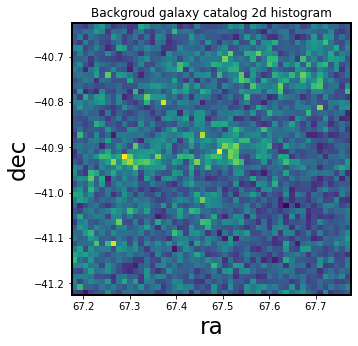

In [13]:
plt.figure(figsize = (5,5))
plt.rcParams['axes.linewidth'] = 2
plt.hist2d(gal_cat['ra'], gal_cat['dec'], cmin = 1, bins = [50, 50])
plt.xlabel('ra', fontsize = 23)
plt.ylabel('dec', fontsize = 23)
plt.title('Backgroud galaxy catalog 2d histogram')
plt.show()

In [14]:
gal_cat['z'] = gal_cat['redshift']

In [15]:
gal_cat = Table(gal_cat)

# 3. Extract photometrical related informations for background galaxies

The full details of the photo-z quantities in the add-on catalog `'cosmoDC2_v1.1.4_small_with_photozs_v1'` are given in the notebook https://github.com/LSSTDESC/DC2-analysis/blob/master/tutorials/extragalactic_gcr_photoz_catalogs.ipynb by Sam Schmidt. This catalog contains photometric redshifts that were computed with the BPZ template-based code (https://ui.adsabs.harvard.edu/abs/2000ApJ...536..571B/abstract). For weak lensing purposes, we extract for each background galaxies in the above sample:
- the probability density function `'photoz_pdf'`
- the mean photometric redshift `'photoz_mean'`

Let's note that the add-on catalog does not support geometrical cut (in ra, dec, redshift). We first extract the photo-z informations in the corresponding contiguous healpix pixels, we then match with the galaxy sample.

In [16]:
%%time
cat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small_with_photozs_v1')

CPU times: user 2.36 s, sys: 1.59 s, total: 3.95 s
Wall time: 4.91 s


In [17]:
%%time
photoz_cat = cat.get_quantities(['photoz_pdf','photoz_mean','redshift', 'galaxy_id'],
                            native_filters=['healpix_pixel=='+str(contiguous_healpix_pixels[0])])

CPU times: user 24.5 s, sys: 19.3 s, total: 43.8 s
Wall time: 43.6 s


We create the astrupy package to match with the galaxy sample.

In [19]:
tab_astropy = Table()
tab_astropy['galaxy_id'] = photoz_cat['galaxy_id']
tab_astropy['photoz_pdf'] =  photoz_cat['photoz_pdf']
tab_astropy['photoz_mean'] =  photoz_cat['photoz_mean']
tab_astropy['photoz_odds'] = photoz_cat['photoz_odds']
mask = np.isin(tab_astropy['galaxy_id'],np.array(gal_cat['galaxy_id']))
tab_cut = tab_astropy[mask]

In [20]:
cat_complete = join(tab_cut, gal_cat, keys = 'galaxy_id')

# 4. Compute the excess surface density

### Estimator of the excess surface density

- The mean excess surface density estimator in radius bin $[R, R + \Delta R[$ is defined by $\widehat{\Delta\Sigma}_+(R) = \frac{1}{\sum\limits_{s = 1} w_{s}}
     \sum\limits_{s= 1}w_{s}\langle\Sigma_{{\rm crit}}(z_s, z_l)^{-1}\rangle^{-1}\epsilon_+^{s}$, where $\epsilon_+^{s}$ is the tangential ellipticity of the background galaxy with index $s$ (source) relative to the dark matter halo position (lens).
     
- where the critical surface mass density expresses as $\Sigma_{{\rm crit}}(z_s, z_l) = \frac{c^2}{4 \pi G} \frac{D_A(z_s)}{D_A(z_l) D_A(z_s, z_l)}$, where $D_A(z_l), D_A(z_s)$ are respectively the angular diameter distance to the lens and to the source, and $D_A(z_s, z_l)$ is the angular diameter distance between the lens and the source.


- and the average is defined as $\langle\Sigma_{\rm crit}(z_s,z_l)^{-1}\rangle = \int_{z_l + 0.1}^{+\infty} d z_s\ p_s(z_s)\Sigma_{\rm crit}(z_s,z_l)^{-1}$, where $p$ is the photometrical probability density function of the background galaxy with index $s$.

### Weights $w_s$

The quantities $w_{s}$ are the weights that maximise the sigmnal-to-noise ratio of the excess surface density estimator. They downweight the galaxies that are close in redshift  to the cluster (where the shape distorsion is small). It also indicates the lack of informations on both redshift and shape measurement for each background galaxies. 

- In the case where there is no error on the shape measurement, the weight $w_{s}$ writes $w_{s} = \langle\Sigma_{\rm crit}(z_s,z_l)^{-1}\rangle^{2}$,

- In the case of true redshift, the PDF reduces to a Dirac function centered at $z_s$, giving the average $\langle\Sigma_{\rm crit}(z_l,z_s)^{-1}\rangle = \Sigma_{\rm crit}(z_l,z_s)^{-1} $ and the weight $w_{ls} = \Sigma_{\rm crit}(z_s,z_l)^{-2}$,


In this notebook, we compute the excess surface density in 3 different cases, using different redshift informations:

- true backgroud galaxy redshift (computation of $w_{ls}^{\rm true}$)
- photometrical probability density function ($w_{ls}^{\rm pdf}$)
- mean photometric redshift ($w_{ls}^{\rm mean}$)

In [38]:
z_bins = cat.photoz_pdf_bin_centers

In [39]:
cosmo = clmm.Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)

In [40]:
sigma_crit_1 = 1/cosmo.eval_sigma_crit(z_min, z_bins)

In [41]:
unormed_integral = scipy.integrate.simps(cat_complete['photoz_pdf'] * sigma_crit_1, x= z_bins, axis = 1)
norm = scipy.integrate.simps(cat_complete['photoz_pdf'], x=z_bins, axis = 1)

In [42]:
ws_pdf = (unormed_integral/norm)**2
ws_true = (1/cosmo.eval_sigma_crit(z_min, cat_complete['redshift']))**2
ws_mean = (1/cosmo.eval_sigma_crit(z_min, cat_complete['photoz_mean']))**2

In [43]:
ws_random = []
for pdf in cat_complete['photoz_pdf']:
    ws_random.append(np.random.choice(1./cosmo.eval_sigma_crit(z_min, z_bins), p = pdf/np.sum(pdf))**2)
ws_random = np.array(ws_random)

### we plot the probability $p_{s} = \frac{w_{s}}{\sum_{s'} w_{s'}}$

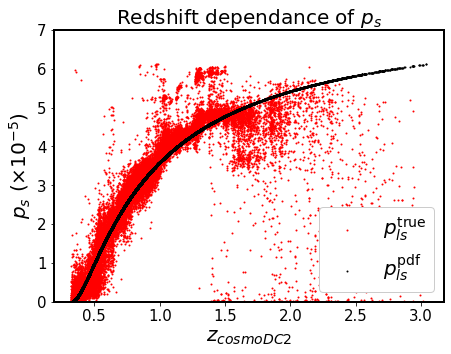

In [45]:
plt.figure(figsize = (7,5))
plt.scatter(cat_complete['redshift'], 1e5*w_ls_photozs/np.sum(ws_pdf), s = 1, c = 'r', label = r'$p_{ls}^{\rm true}$')
plt.scatter(cat_complete['redshift'], 1e5*w_ls_true/np.sum(ws_true), s = 1, c = 'k', label = r'$p_{ls}^{\rm pdf}$')
plt.ylabel(r'$p_{s}\ (\times 10^{-5})$', fontsize = 20)
plt.xlabel(r'$z_{cosmoDC2}$', fontsize = 20)
plt.tick_params(axis='both', which = 'major', labelsize= 15, zorder = 0)
plt.legend(fontsize = 20, loc = 'lower right', frameon = True, framealpha = 1)
plt.ylim(0,7)
plt.title(r'Redshift dependance of $p_{s}$', fontsize = 20)
plt.show()

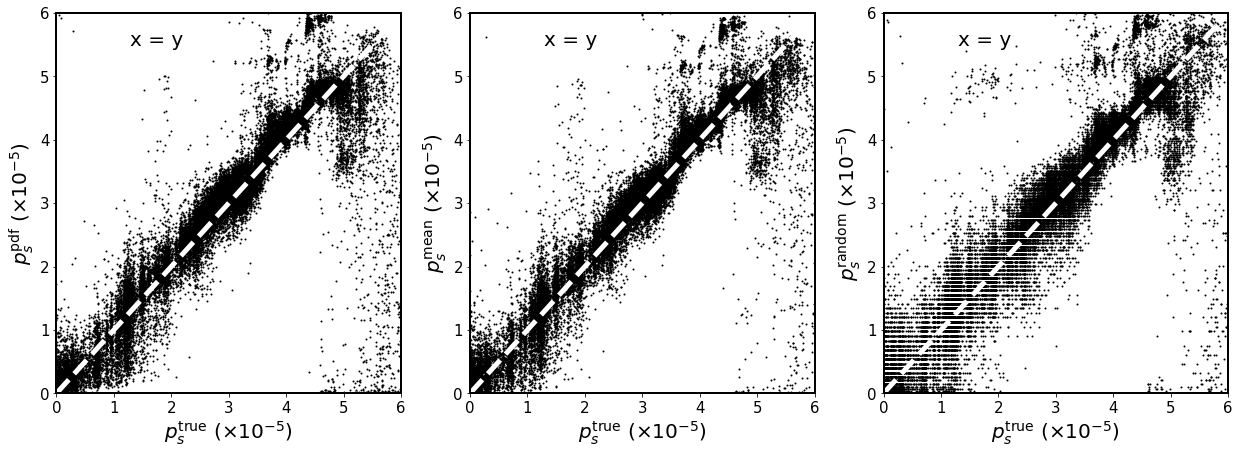

In [47]:
ws_with_photozs = [ws_pdf, ws_mean, ws_random]
label = [r'$p_{s}^{\rm pdf}\ (\times 10^{-5})$', 
         r'$p_{s}^{\rm mean}\ (\times 10^{-5})$', 
         r'$p_{s}^{\rm random}\ (\times 10^{-5})$']

x = np.linspace(0, 7, 100)
fig, axs = plt.subplots(1, 3, figsize = (21,7))
for i in range(3):
    
    axs[i].scatter(1e5 * ws_true/np.sum(ws_true), 1e5 * ws_with_photozs[i]/np.sum(ws_with_photozs[i]), s = 1, c='k')
    axs[i].plot(x,x, '--w', linewidth = 5, label = 'x = y', c = 'w')
    axs[i].set_xlabel(r'$p_{s}^{\rm true}\ (\times 10^{-5})$', fontsize = 20)
    axs[i].set_ylabel(label[i], fontsize = 20)
    axs[i].tick_params(axis='both', which = 'major', labelsize= 15, zorder = 0)
    axs[i].legend(fontsize = 20, loc = 'upper left', frameon = False)
    axs[i].set_ylim(0,6)
    axs[i].set_xlim(0,6)

In [53]:
data = clmm.GCData(cat_complete)
cl = clmm.GalaxyCluster('DM_halo', ra_cl, dec_cl, z_cl, data)
cl.galcat['ws_true'] = np.array(w_ls_true)
cl.galcat['ws_pdf'] = np.array(w_ls_photozs)
cl.galcat['ws_mean'] = np.array(w_ls_mean)
cl.galcat['ws_random'] = np.array(w_ls_random)

We compute the tangential ellipticity for each background galaxy relative to the dark matter halo center

In [54]:
cl.compute_tangential_and_cross_components(
                                    shape_component1='e1', shape_component2='e2', 
                                    tan_component='shear_t', cross_component='shear_x',
                                    geometry="flat")
cl.galcat['r'] = cosmo.eval_da(cl.z)*cl.galcat['theta']

We now compute the excess surface density profile by binning the backgroud galaxy catalog in radial bins and computing the mean excess surface density in each bins using the above equation.

In [55]:
bin_edges = clmm.make_bins(0.1,  6, nbins=10, method='evenlog10width')
radial_bin = [[bin_edges[i], bin_edges[i + 1]] for i in range(len(bin_edges)-1)]

In [56]:
def make_radial_profile(catalog = 1, radius = '', tangential_ellipticity = '', weight = '', radial_bin = 1):

    profile = Table(names=['r', 'DS', 'DS_err'])
    
    for i, r_bin in enumerate(radial_bin):
        
        mask = (catalog.galcat[radius] > r_bin[0])*(catalog.galcat[radius] < r_bin[1])*(catalog.galcat[weight] != 0)

        data_cut = cl.galcat[mask]
        
        r_mean = np.mean(data_cut['r'])

        ds = np.average(data_cut[tangential_ellipticity]*data_cut[weight]**(-0.5), 
                             weights = data_cut[weight])
        
        ds_rms = np.sqrt(np.average((data_cut['shear_t']*data_cut[weight]**(-0.5) - ds)**2, 
                                         weights = data_cut[weight]))/np.sqrt(len(data_cut))

        profile.add_row([r_mean, ds, ds_rms])
        
    return profile

In [58]:
#true redhift
profile_true = make_radial_profile(catalog = cl, radius = 'r', 
                                   tangential_ellipticity = 'shear_t', 
                                   weight = 'ws_true', 
                                   radial_bin = radial_bin)

# using full photometric PDF
profile_pdf = make_radial_profile(catalog = cl, radius = 'r', 
                                  tangential_ellipticity = 'shear_t', 
                                  weight = 'ws_pdf', 
                                  radial_bin = radial_bin)

# using mean photometric redshift
profile_mean = make_radial_profile(catalog = cl, radius = 'r', 
                                   tangential_ellipticity = 'shear_t', 
                                   weight = 'ws_mean', 
                                   radial_bin = radial_bin)

# using random sample of the photometric PDF
profile_random = make_radial_profile(catalog = cl, radius = 'r', 
                                     tangential_ellipticity = 'shear_t', 
                                     weight = 'ws_random', 
                                     radial_bin = radial_bin)

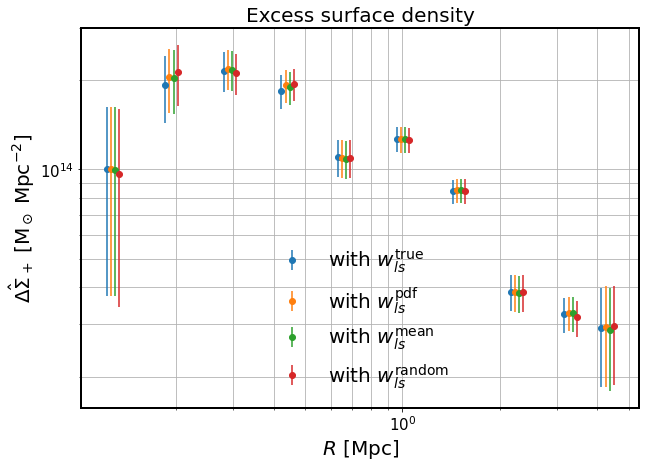

In [66]:
ylabel = r'$\hat{\Delta\Sigma}_+$ ' +'$[$' + r'${\rm M}$' + r'$_\odot\;$'+ r'${\rm Mpc}$'+r'$^{-2}$'r'$]$'
xlabel = r'$R\ [$' + r'${\rm Mpc}$' + r'$]$'
plt.figure(figsize = (10,7))
plt.grid(True, which="both", ls="-")
plt.rcParams['axes.linewidth'] = 2
plt.tick_params(axis='both', which = 'both', labelsize= 15)
deltalogr = 0.03
dr = deltalogr*profile_true['r']
plt.errorbar(profile_true['r']  - 1*dr, profile_true['DS']  , profile_true['DS_err']  , fmt = ' ', marker = 'o', label = r'with $w_{ls}^{\rm true}$')
plt.errorbar(profile_pdf['r']   + 0*dr, profile_pdf['DS']   , profile_pdf['DS_err']   , fmt = ' ', marker = 'o', label = r'with $w_{ls}^{\rm pdf}$')
plt.errorbar(profile_mean['r']  + 1*dr, profile_mean['DS']  , profile_mean['DS_err']  , fmt = ' ', marker = 'o', label = r'with $w_{ls}^{\rm mean}$')
plt.errorbar(profile_random['r']+ 2*dr, profile_random['DS'], profile_random['DS_err'], fmt = ' ', marker = 'o', label = r'with $w_{ls}^{\rm random}$')
plt.loglog()
plt.xlabel(xlabel, fontsize = 20)
plt.ylabel(ylabel, fontsize = 20)
plt.legend(frameon = False, fontsize = 20, loc = 'lower center')
plt.title('Excess surface density', fontsize = 20)
plt.show()